In [1]:
# TODO:
#    1. early stopping not working optuna experiment

In [2]:
import os
import shutil
import pickle
import random
import sys
import numpy as np
import pandas as pd
import duckdb
from typing import List

import requests
from io import StringIO

import ibis
import ibis.selectors as s
from ibis import _
ibis.options.interactive = True

from sklearn.preprocessing import RobustScaler

import torch

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts.dataprocessing import Pipeline
from darts.metrics import mape, smape, mae, ope, rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression, GumbelLikelihood, GaussianLikelihood

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    TFTModel,
    TiDEModel,
    DLinearModel,
    NLinearModel,
    TSMixerModel
)


from torchmetrics import (
    SymmetricMeanAbsolutePercentageError, 
    MeanAbsoluteError, 
    MeanSquaredError,
)

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import mlflow

import warnings
warnings.filterwarnings("ignore")

# logging
import logging

# define log
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

In [3]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
    plot_pareto_front,
)

In [4]:
## will be loaded from root when deployed
# from darts_wrapper import DartsGlobalModel

In [5]:
os.chdir('../..')

In [6]:
# custom modules
import src.data_engineering as de
from src import params
from src import plotting
from src import utils
from src.modeling import get_ci_err, build_fit_tsmixerx, log_pretty

In [7]:
log.info(f'FORECAST_HORIZON: {params.FORECAST_HORIZON}')
log.info(f'INPUT_CHUNK_LENGTH: {params.INPUT_CHUNK_LENGTH}')

INFO:__main__:FORECAST_HORIZON: 120
INFO:__main__:INPUT_CHUNK_LENGTH: 240


## Load model

In [8]:
# mlflow.set_tracking_uri("sqlite:///mlruns.db")
log.info(f'mlflow.get_tracking_uri(): {mlflow.get_tracking_uri()}')
exp_name = 'spp_weis'
exp = mlflow.get_experiment_by_name(exp_name)
exp

INFO:__main__:mlflow.get_tracking_uri(): file:///home/justinfields/Documents/spp_weis_price_forecast/mlruns


<Experiment: artifact_location='file:///home/justinfields/Documents/spp_weis_price_forecast/mlruns/421442998297466818', creation_time=1727527656871, experiment_id='421442998297466818', last_update_time=1727527656871, lifecycle_stage='active', name='spp_weis', tags={}>

In [9]:
runs = mlflow.search_runs(
    experiment_ids = exp.experiment_id,
    # order_by=['metrics.test_mae']
    order_by=['end_time']
    )

runs.sort_values('end_time', ascending=False, inplace=True)
runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.final_ci_error,metrics.test_ci_error,metrics.test_rmse,metrics.final_rmse,...,params.batch_size,params.log_tensorboard,params.input_chunk_length,params.add_encoders,params.ff_size,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.log-model.history,tags.mlflow.runName
5,1760e084643b4e7481f788395958b6a8,421442998297466818,FINISHED,file:///home/justinfields/Documents/spp_weis_p...,2024-09-29 04:25:41.500000+00:00,2024-09-29 04:35:24.301000+00:00,5.444444,3.722222,6.033826,5.337572,...,64,True,240,"{'datetime_attribute': {'future': ['hour', 'da...",16,/home/justinfields/Documents/spp_weis_price_fo...,LOCAL,justinfields,"[{""run_id"": ""1760e084643b4e7481f788395958b6a8""...",adaptable-finch-223
4,91166e2f9d684ba7abe401afe9ffc4c6,421442998297466818,FINISHED,file:///home/justinfields/Documents/spp_weis_p...,2024-09-29 03:35:43.012000+00:00,2024-09-29 03:42:55.832000+00:00,3.888889,3.666667,6.063516,6.072874,...,64,True,240,"{'datetime_attribute': {'future': ['hour', 'da...",16,/home/justinfields/Documents/spp_weis_price_fo...,LOCAL,justinfields,"[{""run_id"": ""91166e2f9d684ba7abe401afe9ffc4c6""...",learned-dolphin-850
3,533c9efcada44d8a925183f49a4a65e2,421442998297466818,FINISHED,file:///home/justinfields/Documents/spp_weis_p...,2024-09-29 02:39:18.528000+00:00,2024-09-29 02:46:36.108000+00:00,3.888889,3.666667,6.063516,6.072874,...,64,True,240,"{'datetime_attribute': {'future': ['hour', 'da...",16,/home/justinfields/Documents/spp_weis_price_fo...,LOCAL,justinfields,"[{""run_id"": ""533c9efcada44d8a925183f49a4a65e2""...",blushing-snipe-276
2,6d71496d31724adba02c314043793fbb,421442998297466818,FAILED,file:///home/justinfields/Documents/spp_weis_p...,2024-09-29 02:37:21.159000+00:00,2024-09-29 02:37:21.164000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,/home/justinfields/Documents/spp_weis_price_fo...,LOCAL,justinfields,None,sassy-hog-694
1,6099c85b627f44b5b0a56f1d9971a502,421442998297466818,FINISHED,file:///home/justinfields/Documents/spp_weis_p...,2024-09-29 00:13:42.848000+00:00,2024-09-29 00:20:56.636000+00:00,3.888889,3.666667,6.063516,6.072874,...,64,True,240,"{'datetime_attribute': {'future': ['hour', 'da...",16,/home/justinfields/Documents/spp_weis_price_fo...,LOCAL,justinfields,"[{""run_id"": ""6099c85b627f44b5b0a56f1d9971a502""...",dazzling-hog-302


In [10]:
best_run_id = runs.run_id.iloc[0]
best_run_id

'1760e084643b4e7481f788395958b6a8'

In [11]:
runs['artifact_uri'].iloc[0]

'file:///home/justinfields/Documents/spp_weis_price_forecast/mlruns/421442998297466818/1760e084643b4e7481f788395958b6a8/artifacts'

In [12]:
model_path = runs['artifact_uri'].iloc[0] + '/GlobalForecasting'

In [13]:
loaded_model = mlflow.pyfunc.load_model(model_path)

INFO:darts_wrapper:MODEL_TYPE: ts_mixer_model


## Prep data

In [14]:
all_df_pd = de.all_df_to_pandas(de.prep_all_df())

In [15]:
lmp = de.prep_lmp()

In [16]:
lmp_pd_df = (
    lmp
    .to_pandas()
    .set_index('timestamp_mst')
)

In [17]:
lmp_pd_df.index.max()

Timestamp('2024-09-23 22:00:00')

In [18]:
# these will be values selected by user
lmp_pd_df.unique_id.unique()

array(['PSCO_BHCE', 'PSCO_CRSP', 'PSCO_MEAN_W', 'PSCO_PRPM_PR',
       'PSCO_PSCM_PSCO_PSCM', 'PSCO_PSCM_PSCP_ARPA',
       'PSCO_PSCO_PSCO_RPSP', 'PSCO_TSPM_TS', 'PSCO_UPIP_UPI'],
      dtype=object)

In [19]:
plot_node_name = 'PSCO_PRPM_PR'
idx = lmp_pd_df.unique_id == 'PSCO_PRPM_PR'
price_df = lmp_pd_df[idx]
price_df

,LMP,unique_id
timestamp_mst,,
2023-05-01 23:00:00,0.940458,PSCO_PRPM_PR
2023-05-02 00:00:00,0.941750,PSCO_PRPM_PR
2023-05-02 01:00:00,2.699692,PSCO_PRPM_PR
2023-05-02 02:00:00,13.471892,PSCO_PRPM_PR
2023-05-02 03:00:00,11.063158,PSCO_PRPM_PR
...,...,...
2024-09-23 18:00:00,27.624017,PSCO_PRPM_PR
2024-09-23 19:00:00,33.024575,PSCO_PRPM_PR
2024-09-23 20:00:00,17.856033,PSCO_PRPM_PR


In [20]:
idx = all_df_pd.unique_id == 'PSCO_PRPM_PR'
node_all_df_pd = all_df_pd[idx]
node_all_df_pd

,unique_id,LMP,Averaged_Actual,MTLF,Wind_Forecast_MW,Solar_Forecast_MW,re_ratio,re_diff
timestamp_mst,,,,,,,,
2024-01-18 15:00:00,PSCO_PRPM_PR,15.749900,9221.0,9159,4050.24,1294.27,0.583525,0.024599
2024-01-18 16:00:00,PSCO_PRPM_PR,17.233333,9457.0,9335,3855.21,980.11,0.517978,-0.065548
2024-01-18 17:00:00,PSCO_PRPM_PR,18.190942,9881.0,9871,3749.28,226.42,0.402766,-0.115212
2024-01-18 18:00:00,PSCO_PRPM_PR,19.639358,10414.0,10418,3744.23,0.35,0.359434,-0.043332
2024-01-18 19:00:00,PSCO_PRPM_PR,19.094050,10458.0,10544,3650.35,0.00,0.346202,-0.013232
...,...,...,...,...,...,...,...,...
2024-10-04 18:00:00,PSCO_PRPM_PR,NaN,NaN,8712,3330.56,51.91,0.388254,-0.043080
2024-10-04 19:00:00,PSCO_PRPM_PR,NaN,NaN,8597,3351.72,0.00,0.389871,0.001617
2024-10-04 20:00:00,PSCO_PRPM_PR,NaN,NaN,8234,3372.83,0.00,0.409622,0.019751


In [21]:
plot_series = de.get_all_series(price_df)[0]

<Axes: xlabel='timestamp_mst'>

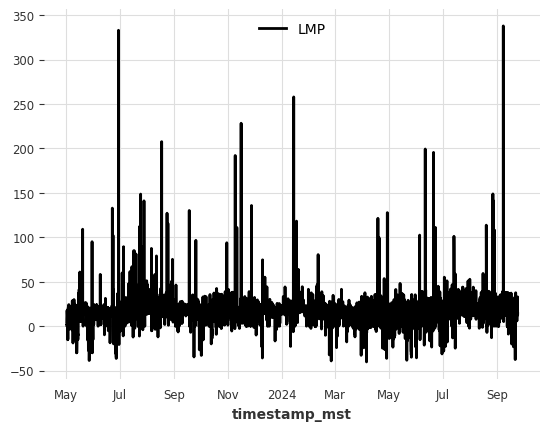

In [22]:
plot_series.plot()

In [23]:
plot_series.static_covariates.unique_id.LMP

'PSCO_PRPM_PR'

In [24]:
plot_series.end_time()

Timestamp('2024-09-23 22:00:00')

<Axes: xlabel='timestamp_mst'>

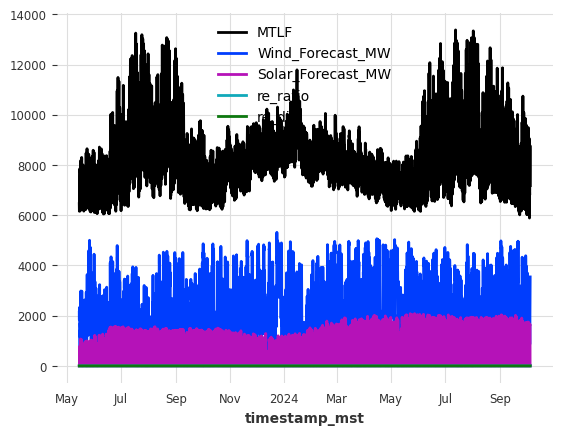

In [25]:
future_cov_series = de.get_futr_cov(node_all_df_pd)[0]
future_cov_series.plot()

In [26]:
future_cov_series.end_time()

Timestamp('2024-10-04 22:00:00')

<Axes: xlabel='timestamp_mst'>

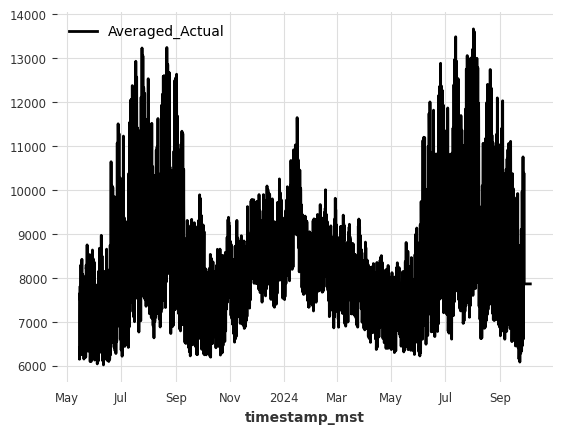

In [27]:
past_cov_series = de.get_past_cov(node_all_df_pd)[0]
past_cov_series.plot()

## Test plotting

In [28]:
# selected by user
forecast_start = pd.Timestamp('2024-07-31') + pd.Timedelta('1h')
forecast_start = plot_series.end_time()  - pd.Timedelta('72h')

In [29]:
node_series = plot_series.drop_after(forecast_start)
log.info(f'node_series.end_time(): {node_series.end_time()}')
# future_cov_series = futr_cov
# past_cov_series = past_cov

INFO:__main__:node_series.end_time(): 2024-09-20 21:00:00


INFO:darts_wrapper:READING INPUTS...
INFO:darts_wrapper:model_input.columns: Index(['series', 'past_covariates', 'future_covariates', 'n', 'num_samples'], dtype='object')
INFO:darts_wrapper:model_input['n']: 120
INFO:darts_wrapper:RUNNING PREDICT...
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                                 …

INFO:src.plotting:node_name: PSCO_PRPM_PR
INFO:src.plotting:title_text: MAE forecast error: $5.94 - CI coverage: 0.767
INFO:src.plotting:title_text: PSCO_PRPM_PR - MAE forecast error: $5.94 - CI coverage: 0.767


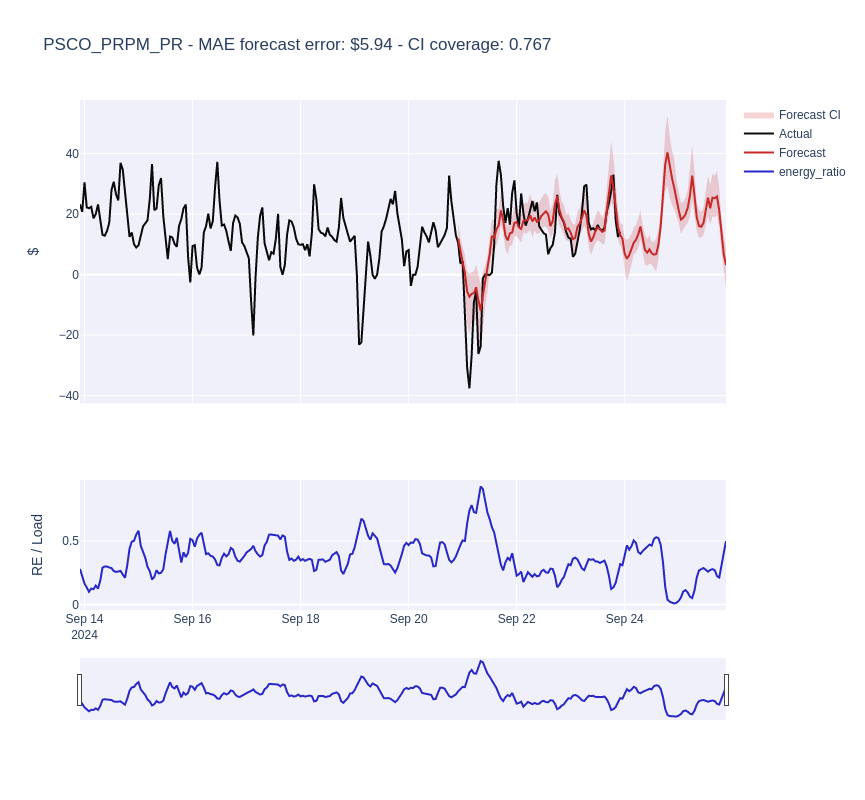

In [32]:
data = {
    'series': [node_series.to_json()],
    'past_covariates': [past_cov_series.to_json()],
    'future_covariates': [future_cov_series.to_json()],
    'n': params.FORECAST_HORIZON,
    'num_samples': 200
}
df = pd.DataFrame(data)

plot_cov_df = future_cov_series.pd_dataframe()
plot_cov_df = (
    plot_cov_df
    .reset_index()
    .rename(columns={'timestamp_mst':'time', 're_ratio': 'Ratio'})
)

# Predict on a Pandas DataFrame.
df['num_samples'] = 500
pred = loaded_model.predict(df)
preds = TimeSeries.from_json(pred)

q_df = plotting.get_quantile_df(preds)

# plot_df = plotting.get_mean_df(preds).merge(
#     plotting.get_quantile_df(preds),
#     left_index=True,
#     right_index=True,
# )

lmp_df = lmp.to_pandas().rename(
    columns={
        'LMP': 'LMP_HOURLY',
        'unique_id':'node', 
        'timestamp_mst':'time'
    })

plot_df = plotting.get_plot_df(
        TimeSeries.from_json(pred),
        plot_cov_df,
        lmp_df,
        plot_node_name,
    )
plot_df.rename(columns={'mean':'mean_fcast'}, inplace=True)
plot_df

plotting.plotly_forecast(plot_df, plot_node_name, show_fig=False)



In [31]:
df

,series,past_covariates,future_covariates,n,num_samples
0,"{""columns"":[""LMP""],""index"":[""2023-05-01T23:00:...","{""columns"":[""Averaged_Actual""],""index"":[""2023-...","{""columns"":[""MTLF"",""Wind_Forecast_MW"",""Solar_F...",120,500
